In [2]:
import pandas as pd



from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score




def evaluate_clf_bin_only(model,x, y, _fig_size,  time_req, labels=['Positives','Negatives']):
        '''
        Visualize the performance of  a Logistic Regression Binary Classifier.

        Displays a labelled Confusion Matrix, distributions of the predicted
        probabilities for both classes, the ROC curve, and F1 score of a fitted
        Binary Logistic Classifier. Author: gregcondit.com/articles/logr-charts

        Parameters
        ----------
        model : fitted scikit-learn model with predict_proba & predict methods
            and classes_ attribute. Typically LogisticRegression or 
            LogisticRegressionCV

        x : {array-like, sparse matrix}, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples
            in the data to be tested, and n_features is the number of features

        y : array-like, shape (n_samples,)
            Target vector relative to x.

        labels: list, optional
            list of text labels for the two classes, with the positive label first

        Displays
        ----------
        4 Subplots

        Returns
        ----------
        
        '''
        #model predicts probabilities of positive class
        print(model)
        p = model.predict_proba(x)
        if len(model.classes_)!=2:
            raise ValueError('A binary class problem is required')
        if model.classes_[1] == 1:
            pos_p = p[:,1]
        elif model.classes_[0] == 1:
            pos_p = p[:,0]

        #FIGURE
        plt.figure(figsize=_fig_size)
        
        y_pred = model.predict(x)        
        
        #1 -- Confusion matrix
        cm = confusion_matrix(y,y_pred)
        plt.subplot(141)
        ax = sns.heatmap(cm, annot=True, cmap='Greens', 
                    annot_kws={"size": 14}, fmt='g')
        cmlabels = ['True Negatives', 'False Positives',
                  'False Negatives', 'True Positives']
        for i,t in enumerate(ax.texts):
            t.set_text(t.get_text() + "\n" + cmlabels[i])
        plt.title('Normalized Confusion Matrix', size=15)
        plt.xlabel('Predicted Values', size=13)
        plt.ylabel('True Values', size=13)

        #2 -- Confusion matrix
        cm = confusion_matrix(y,y_pred)
        plt.subplot(142)
        ax = sns.heatmap(cm, annot=True, cmap='Blues', 
                    annot_kws={"size": 14}, fmt='g')
        cmlabels = ['True Negatives', 'False Positives',
                  'False Negatives', 'True Positives']
        for i,t in enumerate(ax.texts):
            t.set_text(t.get_text() + "\n" + cmlabels[i])
        plt.title('Confusion Matrix', size=15)
        plt.xlabel('Predicted Values', size=13)
        plt.ylabel('True Values', size=13)

        #3 -- Distributions of Predicted Probabilities of both classes
        df = pd.DataFrame({'probPos':pos_p, 'target': y})
        plt.subplot(143)
        plt.hist(df[df.target==1].probPos, density=True, 
                 alpha=.5, color='green',  label=labels[0])
        plt.hist(df[df.target==0].probPos, density=True, 
                 alpha=.5, color='red', label=labels[1])
        plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
        plt.xlim([0,1])
        plt.title('Distributions of Predictions', size=15)
        plt.xlabel('Positive Probability (predicted)', size=13)
        plt.ylabel('Samples (normalized scale)', size=13)
        plt.legend(loc="upper right")

        #4 -- ROC curve with annotated decision point
        fp_rates, tp_rates, _ = roc_curve(y,p[:,1])
        roc_auc = auc(fp_rates, tp_rates)
        plt.subplot(144)
        plt.plot(fp_rates, tp_rates, color='green',
                 lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
        #plot current decision point:
        tn, fp, fn, tp = [i for i in cm.ravel()]
        plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', size=13)
        plt.ylabel('True Positive Rate', size=13)
        plt.title('ROC Curve', size=15)
        plt.legend(loc="lower right")
        plt.subplots_adjust(wspace=.3)
        plt.show()
        #Print and Return the F1 score
        tn, fp, fn, tp = [i for i in cm.ravel()]

        clssname= str(clf.__class__).split(".")[len(str(clf.__class__).split("."))-1].replace(">","").replace("\'","")

        accur = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        F1 = 2*(precision * recall) / (precision + recall)

        FNR = (fn) / (fn + tp)
        TPR = (tp) / (tp + fn)
        TNR = (tn) / (tn + fp)
        FPR = (fp) / (fp + tn)

        res = pd.DataFrame({"Classifier":[clssname]})
        res['AUC'] = str(roc_auc)
        res['Accuracy'] = str(accur)
        res['Precision'] = str(precision)
        res['F1-Score'] = str(recall)
        res['Recall'] = str(F1)
        res['TPR'] = str(TPR)
        res['FNR'] = str(FNR)
        res['FPR'] = str(FPR)
        res['TNR'] = str(TNR)
        res['TN'] = str(tn)
        res['FP'] = str(fp)
        res['FN'] = str(fn)
        res['TP'] = str(tp)        
        res['Time'] = str(time_req)
        return res


from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17,17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=2.8)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues")
#     plt.savefig(filename,  bbox_inches='tight')

## Fetching the data

In [3]:
df = pd.read_csv("data/DDOS Dataset(in).csv")
df.columns = [x.strip().lower().replace(" ", "_") for x in df.columns]


In [4]:
df['label'].value_counts()

DDoS      128027
BENIGN     97718
Name: label, dtype: int64

In [5]:
pd.DataFrame(df.dtypes).value_counts()

int64      54
float64    24
object      1
dtype: int64

In [6]:
df['label'] = df.apply(lambda x: 1 if x['label']=='DDoS' else 0, axis=1)

In [7]:
df

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,61374,61,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
225741,61378,72,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
225742,61375,75,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
225743,61323,48,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0


##  Checking correlation

In [8]:
corr_label  = pd.DataFrame(df.corr()['label']).dropna().sort_values('label')

In [9]:
import seaborn as sns

<Axes: >

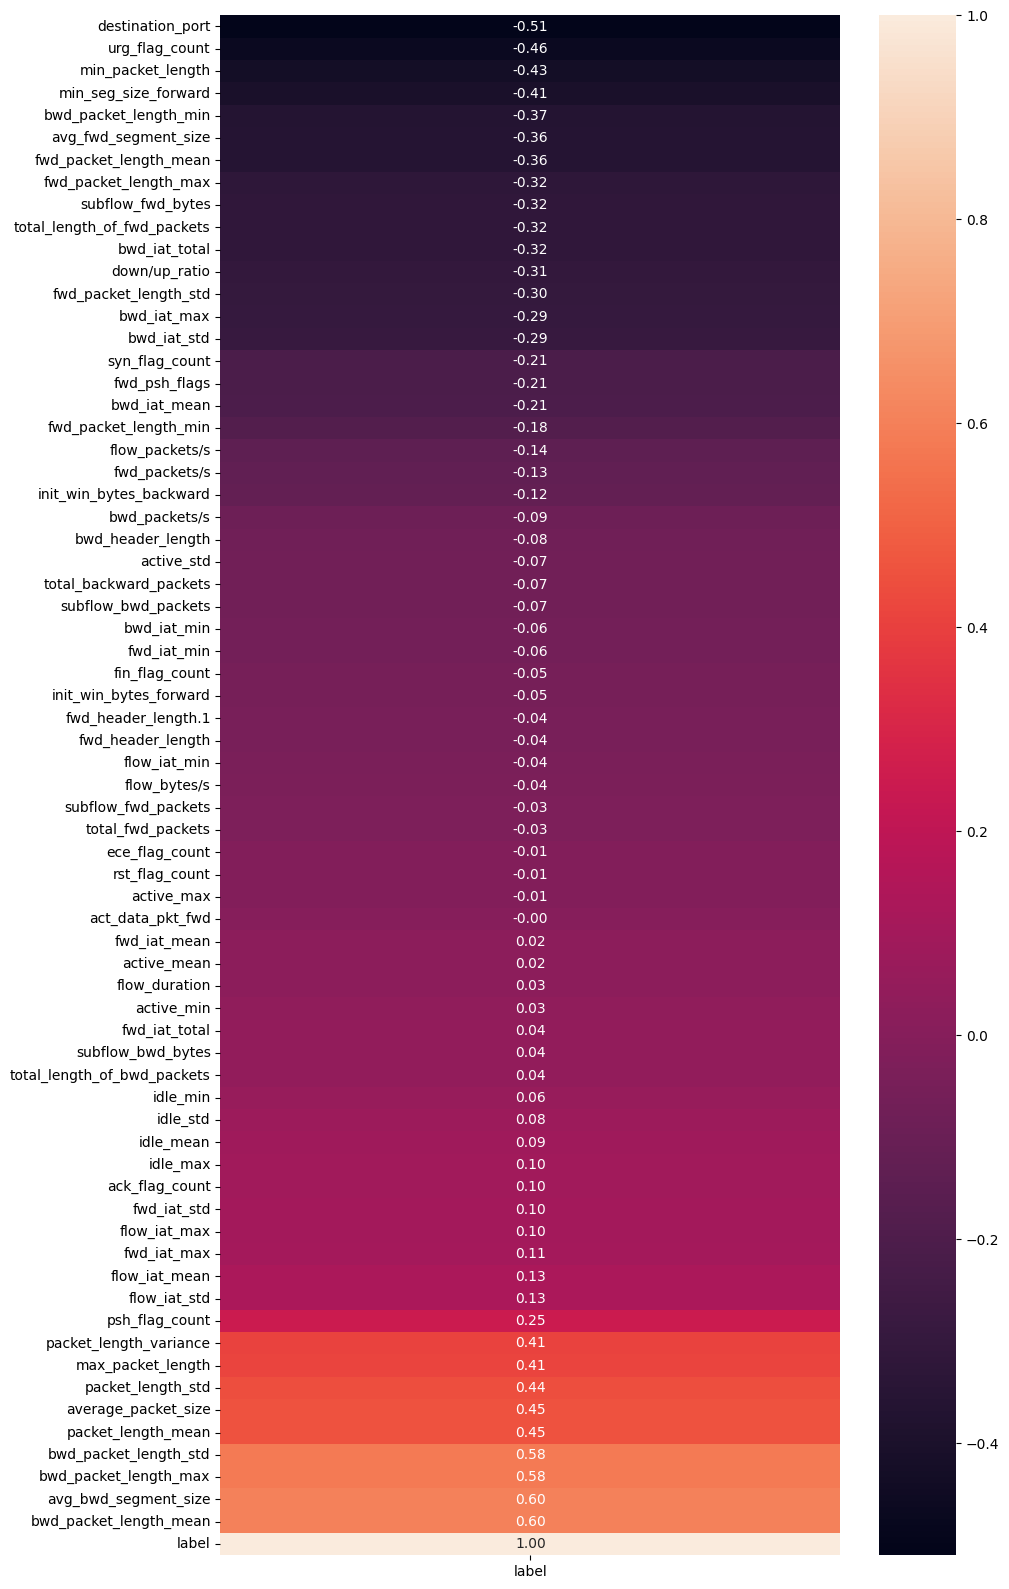

In [10]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,20))         # Sample figsize in inches


sns.heatmap(corr_label, annot=True, fmt=".2f",  ax=ax)


## Picking highly correlated columns

In [11]:
corr_label[(corr_label.label>.3) | (corr_label.label<-.3)].index

Index(['destination_port', 'urg_flag_count', 'min_packet_length',
       'min_seg_size_forward', 'bwd_packet_length_min', 'avg_fwd_segment_size',
       'fwd_packet_length_mean', 'fwd_packet_length_max', 'subflow_fwd_bytes',
       'total_length_of_fwd_packets', 'bwd_iat_total', 'down/up_ratio',
       'fwd_packet_length_std', 'packet_length_variance', 'max_packet_length',
       'packet_length_std', 'average_packet_size', 'packet_length_mean',
       'bwd_packet_length_std', 'bwd_packet_length_max',
       'avg_bwd_segment_size', 'bwd_packet_length_mean', 'label'],
      dtype='object')

In [12]:
top_corr_col_names = ['destination_port', 'urg_flag_count', 'min_packet_length',
       'min_seg_size_forward', 'bwd_packet_length_min', 'avg_fwd_segment_size',
       'fwd_packet_length_mean', 'fwd_packet_length_max', 'subflow_fwd_bytes',
       'total_length_of_fwd_packets', 'bwd_iat_total', 'down/up_ratio',
       'fwd_packet_length_std', 'packet_length_variance', 'max_packet_length',
       'packet_length_std', 'average_packet_size', 'packet_length_mean',
       'bwd_packet_length_std', 'bwd_packet_length_max',
       'avg_bwd_segment_size', 'bwd_packet_length_mean']

array([[<Axes: title={'center': 'destination_port'}>,
        <Axes: title={'center': 'urg_flag_count'}>,
        <Axes: title={'center': 'min_packet_length'}>,
        <Axes: title={'center': 'min_seg_size_forward'}>,
        <Axes: title={'center': 'bwd_packet_length_min'}>],
       [<Axes: title={'center': 'avg_fwd_segment_size'}>,
        <Axes: title={'center': 'fwd_packet_length_mean'}>,
        <Axes: title={'center': 'fwd_packet_length_max'}>,
        <Axes: title={'center': 'subflow_fwd_bytes'}>,
        <Axes: title={'center': 'total_length_of_fwd_packets'}>],
       [<Axes: title={'center': 'bwd_iat_total'}>,
        <Axes: title={'center': 'down/up_ratio'}>,
        <Axes: title={'center': 'fwd_packet_length_std'}>,
        <Axes: title={'center': 'packet_length_variance'}>,
        <Axes: title={'center': 'max_packet_length'}>],
       [<Axes: title={'center': 'packet_length_std'}>,
        <Axes: title={'center': 'average_packet_size'}>,
        <Axes: title={'center': 'p

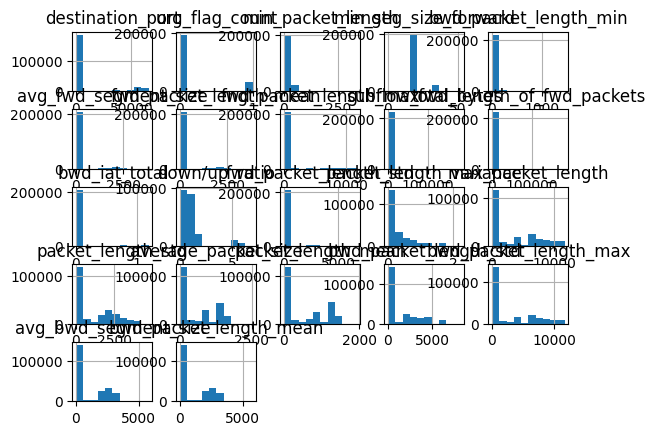

In [13]:
df[top_corr_col_names].hist()

In [14]:
df[top_corr_col_names].dtypes

destination_port                 int64
urg_flag_count                   int64
min_packet_length                int64
min_seg_size_forward             int64
bwd_packet_length_min            int64
avg_fwd_segment_size           float64
fwd_packet_length_mean         float64
fwd_packet_length_max            int64
subflow_fwd_bytes                int64
total_length_of_fwd_packets      int64
bwd_iat_total                    int64
down/up_ratio                    int64
fwd_packet_length_std          float64
packet_length_variance         float64
max_packet_length                int64
packet_length_std              float64
average_packet_size            float64
packet_length_mean             float64
bwd_packet_length_std          float64
bwd_packet_length_max            int64
avg_bwd_segment_size           float64
bwd_packet_length_mean         float64
dtype: object

## Splitting the data

In [17]:

X = df[top_corr_col_names]
y = df.label
X_train, X_test, y_train, y_test = train_test_split(    X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(158021, 22)
(158021,)
(67724, 22)
(67724,)


## initial model training

In [38]:
models = []

# models.append(("SVC",SVC()))
# models.append(("LinearSVC",LinearSVC()))
# models.append(("GaussianNB",GaussianNB))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
models.append(("MLPClassifier",MLPClassifier(solver='lbfgs', random_state=0)))


results = []
names = []
for name,model in models:
    print(model)
    clf = model.fit(X_train, y_train)
    prd = clf.predict(X_test)

    print(accuracy_score(y_test,prd))
    print(precision_score(y_test,prd))
    print(recall_score(y_test,prd))
    print(f1_score(y_test,prd))

    # evaluate_clf_bin_only(name, y_test,prd, _fig_size = (10,10), time_req=10)
    # break
    

DecisionTreeClassifier()
0.9995422597602032
0.99986993054291
0.9993240081119027
0.9995968947895402
RandomForestClassifier()
0.9995127281318292
0.9998439166514919
0.9992980084238989
0.9995708880017684
MLPClassifier(random_state=0, solver='lbfgs')
0.4659795641131652
0.5983381874250471
0.18160782070615153
0.2786420935056646


/home/sajjad/ml_models/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Finalizing the model

In [39]:
final_model = RandomForestClassifier()
clf = final_model.fit(X_train, y_train)
prd = clf.predict(X_test)

print(accuracy_score(y_test,prd))
print(precision_score(y_test,prd))
print(recall_score(y_test,prd))
print(f1_score(y_test,prd))

0.9995127281318292
0.9998439166514919
0.9992980084238989
0.9995708880017684


## saving the model

In [42]:
import pickle

with open('output_model\model.pkl','wb') as f:
    pickle.dump(clf,f)